# Task 2: Train a convolutional autoencoder

The following code trains a convolutional autoencoder on the provided training data. The goal is to learn a compressed representation of the input images.The convolutional autoencoder consists of an encoder that compresses the input images into a lower-dimensional latent space and a decoder that reconstructs the images from this compressed representation. The arhitecture of the network is defined as follows: 
- **Encoder**:
  - Convolutional layer with 16 filters, kernel size 3, stride 2, padding 1, followed by ReLU activation
  - Convolutional layer with 32 filters, kernel size 3, stride 2, padding 1, followed by ReLU activation
  - Flattening layer to convert the 2D feature maps into a 1D vector
  - Fully connected layer to map the flattened vector to the latent space of size `latent_dim`
- **Decoder**:
  - Fully connected layer to map the latent space back to the flattened feature map size
  - Unflattening layer to convert the 1D vector back to 2D feature maps
  - Transposed convolutional layer with 16 filters, kernel size 3, stride 2, padding 1, output padding 1, followed by ReLU activation
  - Transposed convolutional layer with 1 filter, kernel size 3, stride 2, padding 1, output padding 1, followed by Sigmoid activation to produce the final reconstructed image.



In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Hyperparamaters

In [ ]:
batch_size = 32
epochs = 50
lr = 1e-3
latent_dim = 32   # size of compressed representation h = f(x)


# Load & preprocess training data
train_df = pd.read_csv("trainingpix.csv", header=None)

# Features: all columns except last (256 pixels)
X_train = train_df.iloc[:, :-1].values.astype(np.float32)

# Normalize pixel values from {0,1,2} -> [0.0, 1.0]
X_train /= 2.0

# Reshape to (N, C, H, W) required by Conv2d: (N, 1, 16, 16)
X_train = X_train.reshape(-1, 1, 16, 16)

# Convert to tensors and DataLoader (CPU-only)
train_dataset = TensorDataset(torch.tensor(X_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# Convolutional Autoencoder Implementation

In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        # Input: (N,1,16,16)
        # Conv1 -> keep spatial size with padding, produce 16 feature maps
        self.enc_conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # -> (N,16,16,16)
        self.enc_pool = nn.MaxPool2d(2, 2)                           # -> (N,16,8,8)
        # Conv2
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # -> (N,32,8,8)
        # Pool again -> (N,32,4,4)
        
        # Flatten and linear to latent
        self.flatten_size = 32 * 4 * 4  # 512
        self.fc_enc = nn.Linear(self.flatten_size, latent_dim)       # -> (N, latent_dim)
        
        # Decoder
        # Linear back to flattened conv feature-size
        self.fc_dec = nn.Linear(latent_dim, self.flatten_size)       # -> (N, 512)
        # ConvTranspose to upsample: (N,32,4,4) -> (N,16,8,8)
        self.dec_deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        # ConvTranspose: (N,16,8,8) -> (N,1,16,16)
        self.dec_deconv2 = nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2)
        
        # non-linearities
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()  # final activation to map outputs to [0,1]
    
    def encode(self, x):
        x = self.relu(self.enc_conv1(x))   # (N,16,16,16)
        x = self.enc_pool(x)               # (N,16,8,8)
        x = self.relu(self.enc_conv2(x))   # (N,32,8,8)
        x = self.enc_pool(x)               # (N,32,4,4)
        x = x.view(-1, self.flatten_size)  # (N, 512)
        z = self.fc_enc(x)                 # (N, latent_dim)
        return z
    
    def decode(self, z):
        x = self.fc_dec(z)                 # (N, 512)
        x = x.view(-1, 32, 4, 4)           # (N,32,4,4)
        x = self.relu(self.dec_deconv1(x)) # (N,16,8,8)
        x = self.sigmoid(self.dec_deconv2(x)) # (N,1,16,16) mapped to [0,1]
        return x
    
    def forward(self, x):
        z = self.encode(x)
        recon = self.decode(z)
        return recon, z  # return reconstruction and latent vector

In [30]:
# Instantiate model 
autoencoder = ConvAutoencoder(latent_dim=latent_dim)

# MSE loss is common for reconstruction tasks where inputs are continuous in [0,1]
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=lr)


### Training and Visualization

Epoch 1/50 - Reconstruction Loss: 0.095421
Epoch 2/50 - Reconstruction Loss: 0.065923
Epoch 3/50 - Reconstruction Loss: 0.047266
Epoch 4/50 - Reconstruction Loss: 0.038277
Epoch 5/50 - Reconstruction Loss: 0.034066
Epoch 6/50 - Reconstruction Loss: 0.031100
Epoch 7/50 - Reconstruction Loss: 0.028659
Epoch 8/50 - Reconstruction Loss: 0.026485
Epoch 9/50 - Reconstruction Loss: 0.024000
Epoch 10/50 - Reconstruction Loss: 0.021443


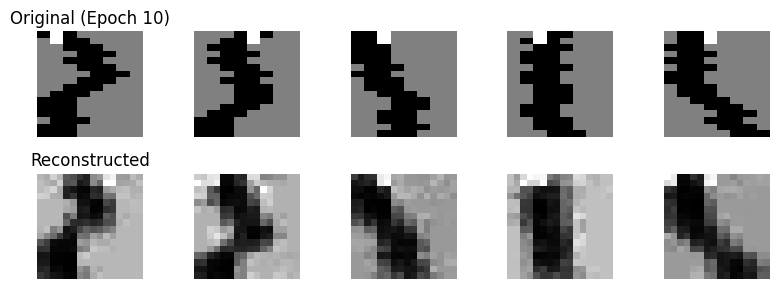

Epoch 11/50 - Reconstruction Loss: 0.019308
Epoch 12/50 - Reconstruction Loss: 0.017692
Epoch 13/50 - Reconstruction Loss: 0.016386
Epoch 14/50 - Reconstruction Loss: 0.015561
Epoch 15/50 - Reconstruction Loss: 0.014865
Epoch 16/50 - Reconstruction Loss: 0.014240
Epoch 17/50 - Reconstruction Loss: 0.013766
Epoch 18/50 - Reconstruction Loss: 0.013237
Epoch 19/50 - Reconstruction Loss: 0.012862
Epoch 20/50 - Reconstruction Loss: 0.012443


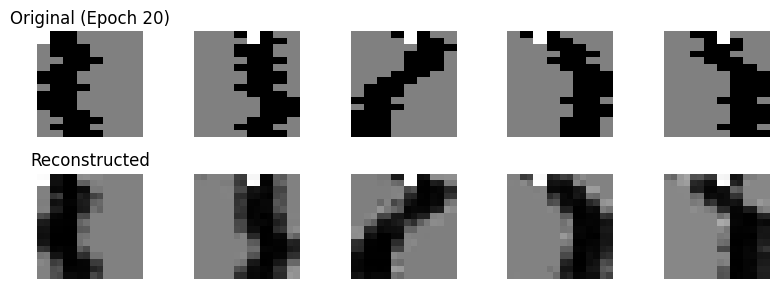

Epoch 21/50 - Reconstruction Loss: 0.012118
Epoch 22/50 - Reconstruction Loss: 0.011789
Epoch 23/50 - Reconstruction Loss: 0.011500
Epoch 24/50 - Reconstruction Loss: 0.011200
Epoch 25/50 - Reconstruction Loss: 0.010896
Epoch 26/50 - Reconstruction Loss: 0.010573
Epoch 27/50 - Reconstruction Loss: 0.010353
Epoch 28/50 - Reconstruction Loss: 0.010066
Epoch 29/50 - Reconstruction Loss: 0.009807
Epoch 30/50 - Reconstruction Loss: 0.009563


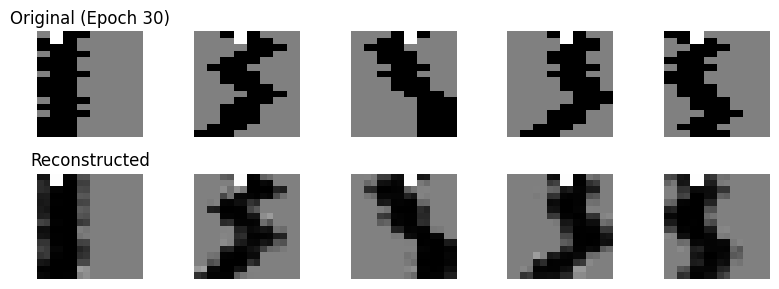

Epoch 31/50 - Reconstruction Loss: 0.009269
Epoch 32/50 - Reconstruction Loss: 0.009022
Epoch 33/50 - Reconstruction Loss: 0.008768
Epoch 34/50 - Reconstruction Loss: 0.008544
Epoch 35/50 - Reconstruction Loss: 0.008325
Epoch 36/50 - Reconstruction Loss: 0.008145
Epoch 37/50 - Reconstruction Loss: 0.007879
Epoch 38/50 - Reconstruction Loss: 0.007679
Epoch 39/50 - Reconstruction Loss: 0.007491
Epoch 40/50 - Reconstruction Loss: 0.007281


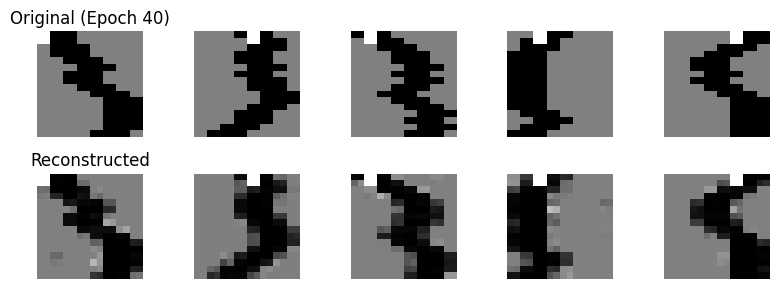

Epoch 41/50 - Reconstruction Loss: 0.007041
Epoch 42/50 - Reconstruction Loss: 0.006823
Epoch 43/50 - Reconstruction Loss: 0.006662
Epoch 44/50 - Reconstruction Loss: 0.006520
Epoch 45/50 - Reconstruction Loss: 0.006306
Epoch 46/50 - Reconstruction Loss: 0.006128
Epoch 47/50 - Reconstruction Loss: 0.005907
Epoch 48/50 - Reconstruction Loss: 0.005700
Epoch 49/50 - Reconstruction Loss: 0.005549
Epoch 50/50 - Reconstruction Loss: 0.005427


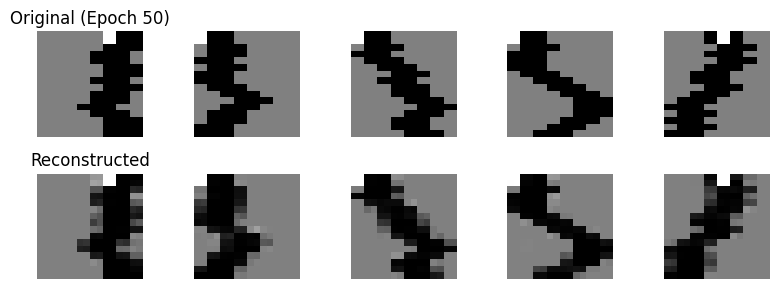

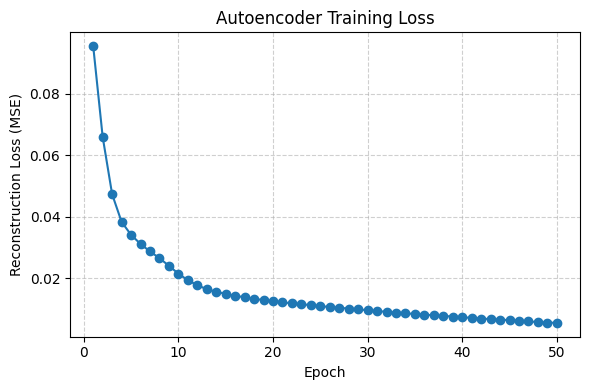

In [31]:
# Visualize some original vs reconstructed images
loss_history = []
visual_epochs = [10, 20, 30, 40, 50]  # epochs where I want to visualize

# Training loop (reconstruction only)
for epoch in range(1, epochs + 1):
    autoencoder.train()
    running_loss = 0.0
    batches = 0
    
    for (X_batch,) in train_loader:  # train_dataset contained single-tensor tuples
        # Forward pass
        recon, _ = autoencoder(X_batch)  # recon shape: (batch_size,1,16,16)
        
        # Compute reconstruction loss (compare recon to original input)
        loss = criterion(recon, X_batch)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        batches += 1
    
    avg_loss = running_loss / batches
    loss_history.append(avg_loss)
    print(f"Epoch {epoch}/{epochs} - Reconstruction Loss: {avg_loss:.6f}")

    # Visualization every 10 epochs 
    if epoch in visual_epochs:
        autoencoder.eval()
        with torch.no_grad():
            (X_batch,) = next(iter(train_loader))
            X_batch = X_batch.to(torch.float32)
            recon, _ = autoencoder(X_batch)

        # Show 5 sample reconstructions
        fig, axes = plt.subplots(2, 5, figsize=(8, 3))
        for i in range(5):
            axes[0, i].imshow(X_batch[i, 0].detach().numpy(), cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].imshow(recon[i, 0].detach().numpy(), cmap='gray')
            axes[1, i].axis('off')

        axes[0, 0].set_title(f"Original (Epoch {epoch})")
        axes[1, 0].set_title("Reconstructed")
        plt.tight_layout()
        plt.show()

# Plot training loss curve at the end 
plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs + 1), loss_history, marker='o')
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss (MSE)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
